In [1]:
# Operating System module for interacting with the operating system
import os

# shutil module for file operations
import shutil

# numpy library for numerical computations
import numpy as np

# pandas library for data manipulation and analysis
import pandas as pd 

# matplotlib library for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# OpenCV library for computer vision tasks
import cv2 

# glob module for file path expansion
import glob

# random module for generating random numbers
import random

# TensorFlow deep learning framework
import tensorflow as tf

# Keras library for neural network modeling
import keras.utils as image

# Setting a seed for reproducibility
random.seed(42)
tf.random.set_seed(42)

# TensorFlow libraries for building neural network layers and applications
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# ImageDataGenerator for real-time data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pickle module for serializing and deserializing Python objects
import pickle

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt

# TensorFlow Keras backend for backend operations
import tensorflow.keras.backend as K


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"




### The model used is VGG16 



### Reading the Data

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/breast-cancer-data

# Accessing the directory containing breast histopathology images
input_directory = "histopathologic-cancer-detection"

data = os.listdir(input_directory)  # List all files in the specified directory

output_directory = "all_images_directory"  # Placeholder for the directory path to organize or process images

In [3]:
# Splitting the data into training and validation sets
# 'data' the dataset containing paths to images and their labels
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

# Further splitting the validation set into validation and test sets
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

# Set preprocessing and hyperparameter settings
# ImageDataGenerator for real-time data augmentation and preprocessing
datagen = ImageDataGenerator(rescale=1./255)  # Normalizing pixel values between 0 and 1
target_size = (50, 50)  # Resizing images to 50x50 pixels
batch_size = 32  # Batch size for training

# Create the training, validation, and test generators
# Generating batches of augmented/normalized data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="path",  # Column containing file paths to the images
    y_col="label",  # Column containing labels for the images
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw'  # 'raw' mode since labels are provided as raw numerical values
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw'
)


Found 56000 validated image filenames.
Found 12000 validated image filenames.
Found 12000 validated image filenames.


In [4]:
# Compute the unique classes and their respective counts in the training generator
A, B = np.unique(train_generator.labels, return_counts=True)

# Calculate the total number of samples in the training set
n = len(train_generator.labels)

# Compute class weights to handle class imbalance
# The dictionary 'cls_weights' will contain class weights for each class
# The formula used for class weighting: weight = (total_samples - count_of_samples_in_class) / total_samples
cls_weights = {i: (n - j) / n for i, j in zip(A, B)}


In [5]:
def calculate_f1_score(true_labels, predicted_labels):
    # Calculate the number of true positives
    true_positive_count = K.sum(K.round(K.clip(true_labels * predicted_labels, 0, 1)))

    # Calculate the number of possible positives (actual positives in true_labels)
    possible_positive_count = K.sum(K.round(K.clip(true_labels, 0, 1)))

    # Calculate the number of predicted positives
    predicted_positive_count = K.sum(K.round(K.clip(predicted_labels, 0, 1)))

    # Calculate precision, recall, and F1 score with epsilon smoothing
    precision = true_positive_count / (predicted_positive_count + K.epsilon())
    recall = true_positive_count / (possible_positive_count + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_score



### Model Optimization

In [6]:
def build_transfer_learning_model(hp):
    # Define the base VGG16 model for transfer learning
    base_model = VGG16(input_shape=(50, 50, 3), include_top=False, pooling='max')

    # Freeze the base model layers to retain pre-trained weights
    for layer in base_model.layers:
        layer.trainable = False

    # Define hyperparameter search space for dense layer units
    units = hp.Int("Dense_units", min_value=50, max_value=100, step=10)

    # Add dense layers for transfer learning model
    x = tf.keras.layers.Dense(units, activation='relu')(base_model.output)
    x = tf.keras.layers.Dense(units // 2, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the transfer learning model
    transfer_learning_model = tf.keras.models.Model(base_model.input, output)

    # Define hyperparameter search space for learning rate
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Compile the transfer learning model with optimizer, loss, and metrics
    transfer_learning_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision(),
            calculate_f1_score  # Assuming 'calculate_f1_score' is a function defined elsewhere
        ]
    )

    return transfer_learning_model


In [7]:
# Define a Hyperband tuner for hyperparameter optimization
tuner = kt.Hyperband(
    hp_model,  # The hyperparameter model function to optimize
    objective=kt.Objective('f1_score', 'max'),  # Objective to maximize (in this case, 'f1_score')
    max_epochs=10,  # Maximum number of epochs for training
    factor=3,  # Reduction factor for the number of models and epochs
    directory='Optimizations',  # Directory to store tuning results
    project_name='vgg16Optimization'  # Name of the tuning project
)


In [8]:
# Define an EarlyStopping callback to stop training when validation loss doesn't improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search using the tuner
tuner.search(
    train_generator,  # Training data generator
    epochs=50,  # Number of epochs for hyperparameter search
    validation_data=val_generator,  # Validation data generator
    callbacks=[stop_early]  # Early stopping callback to prevent overfitting
)

# Get the best hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



### Training the Final Model

In [10]:
def build_transfer_learning_model(learning_rate, dense_units):
    # Load VGG16 pre-trained model as base_model
    base_model = VGG16(input_shape=(50, 50, 3), include_top=False, pooling='max')

    # Freeze the layers of the base_model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom dense layers for transfer learning
    dense_layer_1 = tf.keras.layers.Dense(dense_units, activation='relu')(base_model.output)
    dense_layer_2 = tf.keras.layers.Dense(dense_units // 2, activation='relu')(dense_layer_1)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer_2)

    # Create the transfer learning model
    transfer_learning_model = tf.keras.models.Model(base_model.input, output_layer)

    # Compile the transfer_learning_model
    transfer_learning_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision(),
            f1_score  # Assuming 'f1_score' is a function defined elsewhere
        ]
    )

    # Train the transfer_learning_model
    training_history = transfer_learning_model.fit(
        train_data_generator,
        epochs=300,
        validation_data=val_data_generator,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001),
        class_weight=class_weights
    )

    # Evaluate the trained model on the test dataset
    test_results = transfer_learning_model.evaluate(test_data_generator)

    # Return the trained model, training history, and test results
    return transfer_learning_model, training_history, test_results


In [11]:
# Best hyperparameters obtained from Keras Tuner
best_hyperparameters = {
    'dense_units': 100,
    'learning_rate': 0.001
}

# Train the best transfer learning model using the best hyperparameters
trained_model, training_history, test_results = build_transfer_learning_model(**best_hyperparameters)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/300
1750/1750 [==============================] - 323s 179ms/step - loss: 0.1992 - recall: 0.7521 - precision: 0.5935 - f1_score: 0.6537 - val_loss: 0.4483 - val_recall: 0.7466 - val_precision: 0.6334 - val_f1_score: 0.6720
Epoch 2/300
1750/1750 [==============================] - 73s 42ms/step - loss: 0.1871 - recall: 0.7763 - precision: 0.6173 - f1_score: 0.6780 - val_loss: 0.4509 - val_recall: 0.7838 - val_precision: 0.6138 - val_f1_score: 0.6794
Epoch 3/300
1750/1750 [==============================] - 72s 41ms/step - loss: 0.1831 - recall: 0.7830 - precision: 0.6212 - f1_score: 0.6832 - val_loss: 0.4722 - val_recall: 0.8148 - val_precision: 0.5828 - val_f1_score: 0.6687
Epoch 4/300
1750/1750 [==============================] - 73s 42ms/step - loss: 0.1799 - recall: 0.7902 - precision: 0.6271 - f1_score: 0.6893 - val_loss: 0.4175 - val_recall: 0.7569 - val_precision: 0.6403 - val_f1_score: 0.6836
Epoch 5/300
1750/

/tmp/ipykernel_31/2973932866.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


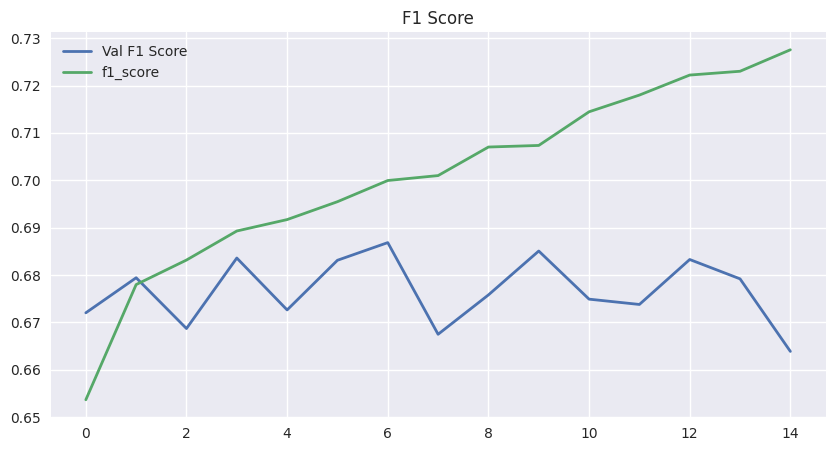

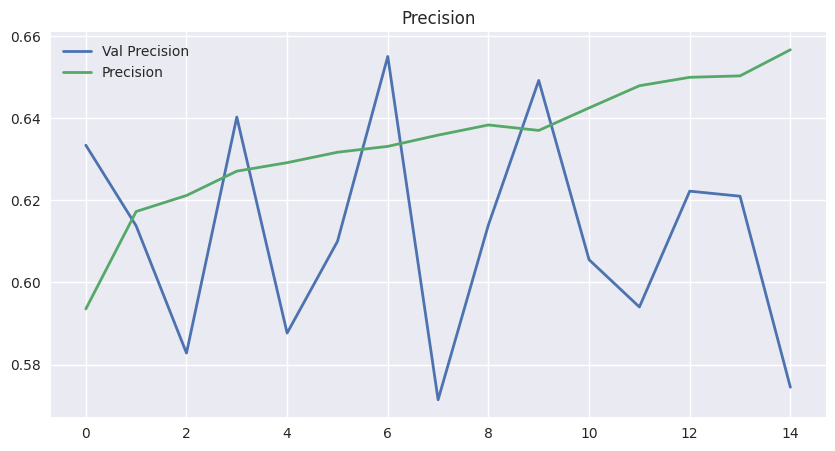

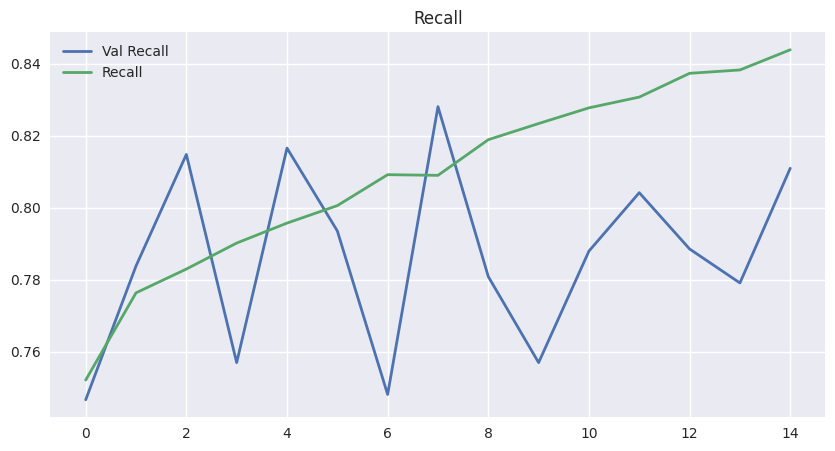

In [13]:
def plot_metrics(history):
    # Plot validation and training F1 score
    plt.style.use('seaborn')
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['val_f1_score'], label='Validation F1 Score', linewidth=2)
    plt.plot(history.epoch, history.history['f1_score'], label='Training F1 Score', linewidth=2)
    plt.legend()
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    # Plot validation and training Precision
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['val_precision'], label='Validation Precision', linewidth=2)
    plt.plot(history.epoch, history.history['precision'], label='Training Precision', linewidth=2)
    plt.legend()
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.show()

    # Plot validation and training Recall
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['val_recall'], label='Validation Recall', linewidth=2)
    plt.plot(history.epoch, history.history['recall'], label='Training Recall', linewidth=2)
    plt.legend()
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

# Plot the metrics from the training history
plot_metrics(training_history)


In [14]:
# Print test results
print("Test Results")
print("Test Loss:", format(test_results[0], '.3f'))  # Print test loss with 3 decimal places
print("Test Precision:", format(test_results[1], '.3f'))  # Print test precision with 3 decimal places
print("Test Recall:", format(test_results[2], '.3f'))  # Print test recall with 3 decimal places
print("Test F1:", format(test_results[3], '.3f'))  # Print test F1 score with 3 decimal places


Test Results

-------------

Test Loss: 0.510
Test Precision:  0.822
Test Recall:  0.570
Test F1: 0.661


In [ ]:
# Save the trained model
model.save('modelVGG16.h5')
